# Exploratory Data Analysis 

In [1]:
# Import neccessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
import seaborn as sns
%matplotlib inline

import nltk
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words

In [2]:
train = pd.read_csv('../mercari/train.tsv', sep='\t')
test = pd.read_csv('../mercari/test.tsv', sep='\t')

In [3]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [4]:
train.shape

(1482535, 8)

In [5]:
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [6]:
test.shape

(693359, 7)

In [7]:
train.dtypes
# train.groupby('shipping')['price'].mean()
# train.groupby('item_condition_id')['price'].mean()

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

On the first look at the data, besides the unique identifier (item_id), there are 6 variables in this model. This notebook will sequentially go through each of them with a brief statistical summary. 
Some explaination of these features:
1. name: the title of the listing
2. item_condition_id: the condition of the items provided by the seller
3. category_name: category of the listing
4. brand_name
5. shipping: 1 if shipping fee is paid by seller and 0 by buyer
6. item_description: the full description of the item. 
7. price: the price that the item was sold for. This is the target variable that you will predict. The unit is USD.

## Target Variable: Price 

In [8]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

In [9]:
train.price.min()

0.0

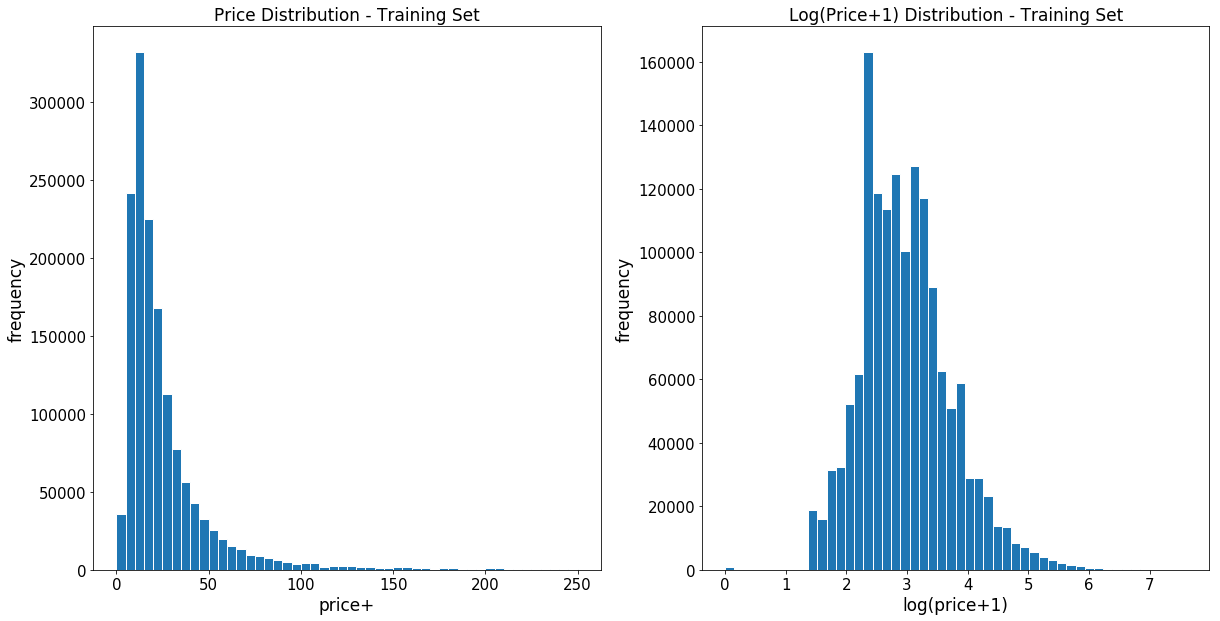

In [10]:
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(20,10), edgecolor='white',range=[0,250])
plt.xlabel('price+', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Price Distribution - Training Set', fontsize=17)

plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(20,10), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Price+1) Distribution - Training Set', fontsize=17)
plt.show()

## Shipping
The percentage of shipping fees paid by users is 55.27%; The avearage price of these items is 30.11.
The percentage of shipping fees paid by sellers is 44.72%; The avearage price of these items is 22.56.

In [11]:
train['shipping'].value_counts()/len(train)

0    0.552726
1    0.447274
Name: shipping, dtype: float64

In [12]:
train.groupby('shipping')['price'].mean()

shipping
0    30.111778
1    22.567726
Name: price, dtype: float64

Average price of items shipped by buyers 0 = 30.11
Average price of items shipped by seller 1 = 22.57


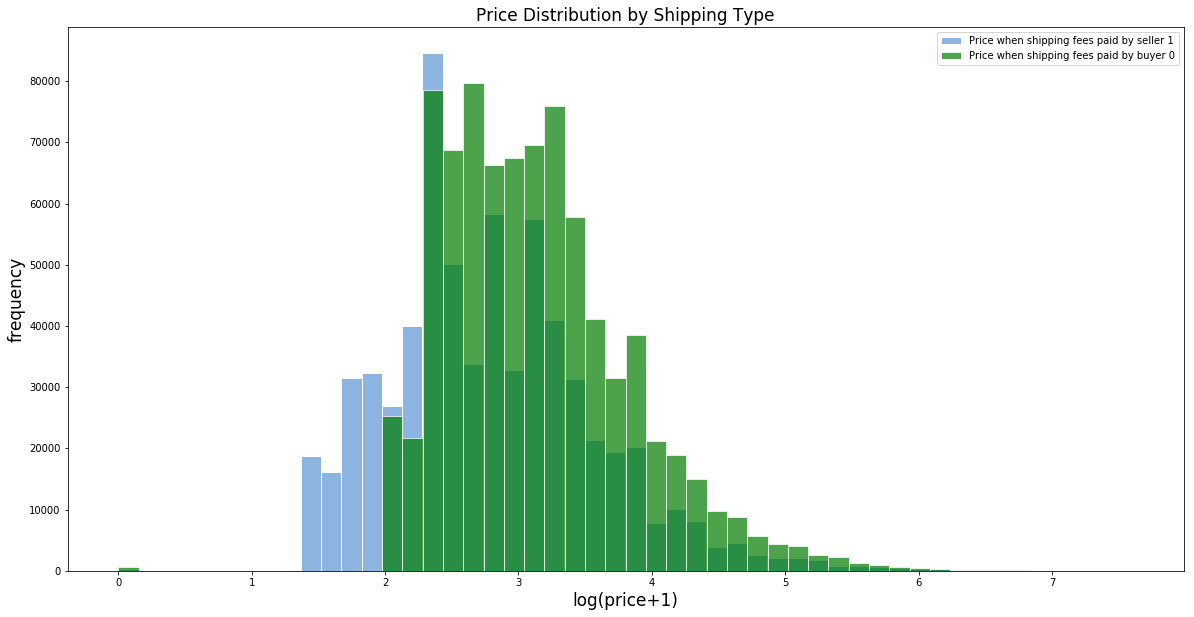

In [13]:
prc_shipByBuyer0 = train.loc[train.shipping==0, 'price']
prc_shipBySeller1 = train.loc[train.shipping==1, 'price']

print("Average price of items shipped by buyers 0 = %2.2f" %  prc_shipByBuyer0.mean())
print("Average price of items shipped by seller 1 = %2.2f" %  prc_shipBySeller1.mean())

# Plot histograms of Average price of items shipped by buyers 0 adn seller 1
fig, ax = plt.subplots(figsize=(20,10))
ax.hist(np.log(prc_shipBySeller1+1), color='#8CB4E1', alpha=1.0, bins=50, edgecolor='white',
       label='Price when shipping fees paid by seller 1')
ax.hist(np.log(prc_shipByBuyer0+1), color='#007D00', alpha=0.7, bins=50, edgecolor='white',
       label='Price when shipping fees paid by buyer 0')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.title('Price Distribution by Shipping Type', fontsize=17)
plt.legend(loc='upper right')


## Item Condition


In [14]:
train['item_condition_id'].value_counts()/len(train)

1    0.432063
3    0.291501
2    0.253268
4    0.021559
5    0.001608
Name: item_condition_id, dtype: float64

In [15]:
train.groupby('item_condition_id')['price'].mean()

item_condition_id
1    26.486967
2    27.563225
3    26.540711
4    24.349212
5    31.703859
Name: price, dtype: float64

## Category 

In [16]:
print("There are %d unique values in the category column." % train['category_name'].nunique())

There are 1287 unique values in the category column.


In [17]:
# TOP 5 RAW CATEGORIES
train['category_name'].value_counts()[:5]

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
Name: category_name, dtype: int64

In [18]:
# missing categories
print("There are %d items that do not have a label." % train['category_name'].isnull().sum())

There are 6327 items that do not have a label.


In [19]:
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")

In [20]:
train['general_cat'], train['subcat_1'], train['subcat_2'] = \
zip(*train['category_name'].apply(lambda x: split_cat(x)))
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [21]:
# repeat the same step for the test set
test['general_cat'], test['subcat_1'], test['subcat_2'] = \
zip(*test['category_name'].apply(lambda x: split_cat(x)))

In [22]:
print("There are %d unique general-categories." % train['general_cat'].nunique())
print("There are %d unique first sub-categories." % train['subcat_1'].nunique())
print("There are %d unique second sub-categories." % train['subcat_2'].nunique())

There are 11 unique general-categories.
There are 114 unique first sub-categories.
There are 871 unique second sub-categories.


In [24]:
x = train['general_cat'].value_counts().index.values.astype('str')
y = train['general_cat'].value_counts().values
pct = [("%.2f"%(v*100))+"%"for v in (y/len(train))][:15]
trace1 = go.Bar(x=x, y=y, text=pct,
                marker=dict(
                color = y,colorscale='Portland',showscale=True,
                reversescale = False
                ))
layout = dict(title= 'Number of Items by General Category',
              yaxis = dict(title='Count'),
              xaxis = dict(title='General Category'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

In [25]:
x = train['subcat_1'].value_counts().index.values.astype('str')[:10]
y = train['subcat_1'].value_counts().values[:10]
pct = [("%.2f"%(v*100))+"%"for v in (y/len(train))][:10]
trace1 = go.Bar(x=x, y=y, text=pct,
                marker=dict(
                color = y,colorscale='Portland',showscale=True,
                reversescale = False
                ))
layout = dict(title= 'Number of Items by First SubCategory (Top 10)',
              yaxis = dict(title='Count'),
              xaxis = dict(title='First SubCategory'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

## Brand Name 

In [26]:
print("There are %d unique brand names in the training dataset." % train['brand_name'].nunique())

There are 4809 unique brand names in the training dataset.


In [27]:
# missing brand name
print("There are %d items that do not have a label." % train['brand_name'].isnull().sum())

There are 632682 items that do not have a label.


In [28]:
x = train['brand_name'].value_counts().index.values.astype('str')[:10]
y = train['brand_name'].value_counts().values[:10]
pct = [("%.2f"%(v*100))+"%"for v in (y/len(train))][:15]
trace1 = go.Bar(x=x, y=y, text=pct,
                marker=dict(
                color = y,colorscale='Portland',showscale=True,
                reversescale = False
                ))
layout = dict(title= 'Number of Items by Brand Name (Top 10)',
              yaxis = dict(title='Count'),
              xaxis = dict(title='Brand Name'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)